In [86]:
from utils import Candidate
from utils import Quadrant
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
import astropy.wcs as wcs
#from crowdsource import crowdsource_base

import psf
import crowdsource_base

### Goal:
1. Do Dr. Knop's crowdsource on the reference image. Make sure the model and subtraction are much better.
2. Generate a reference csv file.
3. Based on the reference csv file, do Dr. Knop's crowdsource on another random image. Make sure the model and subtraction are much better.
4. Experiment with using gaussian vs. moffat psfs and toggling the refit_sky and other parameters on and off.

In [87]:
# Get the reference and test images

name = "DC21saaw"
radec = (270.31184, -28.77637)
c = Candidate(name, radec)
c.start()
iid = c.get_image_ids()
imref_fp, wref_fp = c.get_fp("c4d_210322_091756_ori") # Tuple of image and weight file
imfnames, wfnames = zip(*c.get_all_fps()) # List of tuples of image and weight files
c.close()

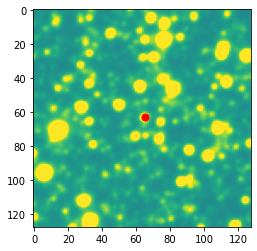

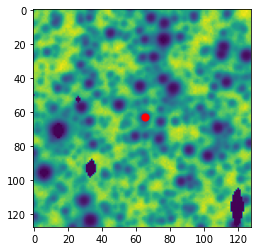

In [339]:
# STEP 1: Get Reference Image Centered on Ra/Dec

s = 64
radec = (270.31177, -28.776405) # Updated ra/dec manually
radec = (270.31178, -28.77640)

imhdul = fits.open(imref_fp) # get a file
weighthdul = fits.open(wref_fp)

# imhdul = fits.open(imfnames[0]) # get a file
# weighthdul = fits.open(wfnames[0])


q = Quadrant(imhdul, (2*s, 2*s)) # start a tile
xrel, yrel = q.get_rel_xy((radec[0], radec[1]))


# PLOT QUADRANT IMAGE
subim, c = q.get_tile((radec[0], radec[1])) # Get the image centered on the int near radect
ymin, ymax, xmin, xmax = c
weight = np.flipud(weighthdul[1].data[c[2]:c[3], c[0]:c[1]])

plt.imshow(subim, vmin=-1600, vmax=1600)
plt.scatter(xrel, yrel, s=50, color = "red", alpha = 1) # plot the center and the x/y for ra/dec
plt.show()

vmin, vmax = ZScaleInterval().get_limits(weighthdul[1].data)
plt.imshow(weight, vmin=vmin, vmax=vmax)
plt.scatter(xrel, yrel, s=50, color = "red", alpha = 1) # plot the center and the x/y for ra/dec
plt.show()

Extension None, iteration  1, found    127 sources;    0 close and    0 faint sources removed.
Extension None, iteration  2, found     47 sources;    0 close and    2 faint sources removed.
Extension None, iteration  3, found      2 sources;    0 close and    0 faint sources removed.
Extension None, iteration  4, found      5 sources;    0 close and    0 faint sources removed.
starting reference image


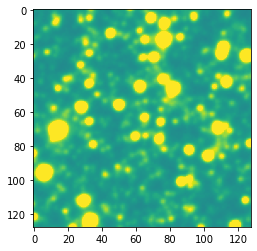

reference model image


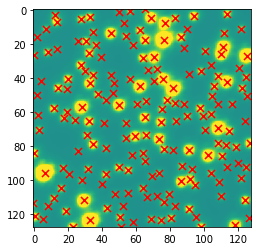

reference difference image


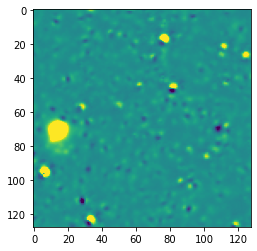

In [340]:
# STEP 2: Do Crowdsource on the reference image

psf_ = psf.gaussian_psf(4, deriv=False) # get the psf stamps
psf_ = np.reshape(psf_, (19, 19)) # reshape the psf into the shape the SimplePSF object needs.
psf__ = psf.SimplePSF(psf_) # make a SimplePSF psf object with the stamps.

#psf__ = psf.MoffatPSF(4, beta=3)
    
#CROWDSOURCE GET XS AND YS
pars = crowdsource_base.fit_im(subim, psf__, weight=weight, 
                           verbose=True, miniter=4, maxiter=10, 
                           refit_psf=True, derivcentroids=True, refit_sky = False) # Get the crowdsource fit (including sky subtraction).

print("starting reference image")
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.show()

print("reference model image")
plt.imshow(pars[1], vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference difference image")
plt.imshow(subim - pars[1], vmin=-1600, vmax=1600 )
plt.show()

starting reference image


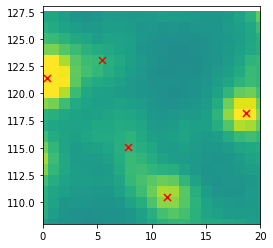

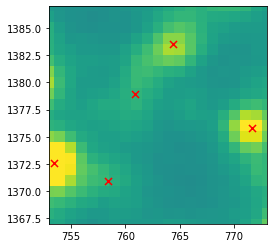

In [341]:
# STEP 3: Transform xy relative coordinates to full x y coordinates
import matplotlib.patches as patches

# Plot the crowdsource positions over the image
print("starting reference image")

fig, ax = plt.subplots()
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")

# points = [(0, 128 - 20), (0, 128), (20, 128), (20, 128-20)]
# rect = patches.Polygon(points, linewidth=5, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# plt.xlim(60, 128-60)
# plt.ylim(56, 128-60)

# plt.xlim(40, 128-40)
# plt.ylim(40, 128-40)

plt.xlim(0, 20)
plt.ylim(128-20, 128)
# plt.xlim(0, 20)
# plt.ylim(0, 20)
plt.show()



# Calculate the full positions
ypre = np.reshape(pars[0]["y"], (pars[0]["x"].shape[0], 1)) - s

xpre = np.reshape(pars[0]["x"], (pars[0]["x"].shape[0], 1)) - s

y = -1*xpre
x = ypre

ypre = y + s - 1

# ypre = y + s
xpre = x + s

xref = xpre + ymin
yref = ypre + xmin



# Plot the full crowdsource positions over the image, zoom in with xlim/ylim

fig, ax = plt.subplots()
ax.imshow(imhdul[1].data, vmin=-1600, vmax=1600 )
ax.scatter(xref, yref, s=50, color = "red", alpha = 1, marker = "x")


# points = [(xmin, ymin), (xmin, ymin + 20), (xmin + 20, ymin + 20), (xmin + 20, 0)]
# points = [(ymin, xmin), (ymin, xmin + 20), (ymin + 20, xmin + 20), (ymin + 20, xmin)]
# rect = patches.Polygon(points, linewidth=5, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

plt.xlim(ymin, ymax)
plt.ylim(xmin, xmax)

plt.xlim(ymin - 0, ymin + 20)
plt.ylim(xmin - 0, xmin + 20)

plt.show()

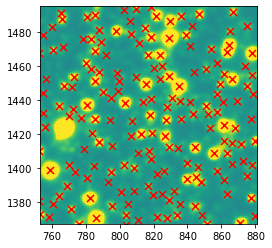

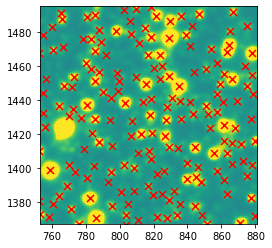

In [342]:
# STEP 4: Transform xy full coordinates to Ra/Decs

# Plot the full image with xy full coordinates
fig, ax = plt.subplots()
ax.imshow(imhdul[1].data, vmin=-1600, vmax=1600 )
ax.scatter(xref, yref, s=50, color = "red", alpha = 1, marker = "x")

plt.xlim(ymin, ymax)
plt.ylim(xmin, xmax)

plt.show()


# Convert to xy full coordinates to Ra/Decs
ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
radecs = ws.wcs_pix2world(np.transpose(np.array([xref, yref]))[0], 0)  # return the Ra/Dec positions as a numpy array


# Convert back to xy full coordinates and plot the full image
xys = ws.wcs_world2pix(radecs, 0)
x = np.transpose(xys)[0]
y = np.transpose(xys)[1]

fig, ax = plt.subplots()
ax.imshow(imhdul[1].data, vmin=-1600, vmax=1600 )
ax.scatter(x, y, s=50, color = "red", alpha = 1, marker = "x")

plt.xlim(ymin, ymax)
plt.ylim(xmin, xmax)

plt.show()

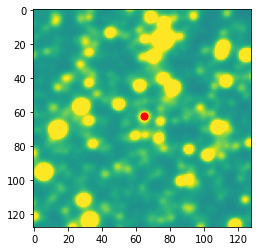

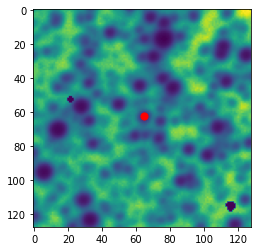

In [343]:
# STEP 5 & 6: Grab another image and center it on the Ra/Dec

imhdul = fits.open(imref_fp) # get a file
weighthdul = fits.open(wref_fp)

imhdul = fits.open(imfnames[21]) # get a file
weighthdul = fits.open(wfnames[21])


q = Quadrant(imhdul, (2*s, 2*s)) # start a tile
xrel, yrel = q.get_rel_xy((radec[0], radec[1]))


# PLOT QUADRANT IMAGE
subim, c = q.get_tile((radec[0], radec[1])) # Get the image centered on the int near radect
ymin, ymax, xmin, xmax = c
weight = np.flipud(weighthdul[1].data[c[2]:c[3], c[0]:c[1]])

plt.imshow(subim, vmin=-1600, vmax=1600)
plt.scatter(xrel, yrel, s=50, color = "red", alpha = 1) # plot the center and the x/y for ra/dec
plt.show()

vmin, vmax = ZScaleInterval().get_limits(weighthdul[1].data)
plt.imshow(weight, vmin=vmin, vmax=vmax)
plt.scatter(xrel, yrel, s=50, color = "red", alpha = 1) # plot the center and the x/y for ra/dec
plt.show()

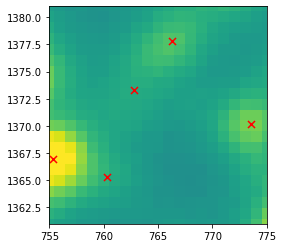

In [344]:
# STEP 7: Transform the radecs to full coords using the new image header

ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
xys = ws.wcs_world2pix(radecs, 0)  # return the Ra/Dec positions as a numpy array

x = np.transpose(xys)[0]
y = np.transpose(xys)[1]

fig, ax = plt.subplots()
ax.imshow(imhdul[1].data, vmin=-1600, vmax=1600 )
ax.scatter(x, y, s=50, color = "red", alpha = 1, marker = "x")

plt.xlim(ymin, ymax)
plt.ylim(xmin, xmax)

# plt.xlim(ymin + 60, ymax - 60)
# plt.ylim(xmin + 60, xmax - 60)

plt.xlim(ymin - 0, ymin + 20)
plt.ylim(xmin - 0, xmin + 20)


plt.show()

-0.5904857344939956 -0.8420409900920731


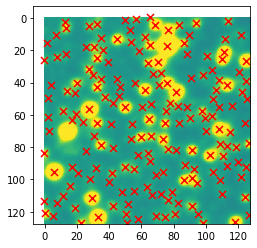

In [348]:
# STEP 8: Transform full xy coordinates to relative xy coordinates

fig, ax = plt.subplots()
ax.imshow(subim, vmin=-1600, vmax=1600 )

xs = x - ymin
ys = y - xmin

xs = xs - s
ys = ys - s + 1

# ys_ = xs
# xs_ = -1*ys

ys_ = -1*ys
xs_ = -1*xs

# ys_ = -1*xs
# xs_ = ys

# ys_ = ys
# xs_ = xs

ys_ = ys_ + s
xs_ = xs_ + s
xs_ = 2*s - xs_

# ypre = ys + s - 1
# xpre = xs + s

# xref = xpre + ymin
# yref = ypre + xmin

ax.scatter(xs_, ys_, s=50, color = "red", alpha = 1, marker = "x")

print(min(xs_), min(ys_))
# plt.xlim(20, 40)
# plt.ylim(20, 40)

Some positions within 0.01 pix of edge of image clipped back to 0.01 pix inside image.
Some positions within 0.01 pix of edge of image clipped back to 0.01 pix inside image.
Iteration 1, median sky   0.00
Iteration 2, median sky  47.73
Iteration 3, median sky  43.39
Iteration 4, median sky  42.82
starting reference image


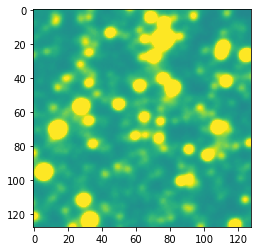

reference model image


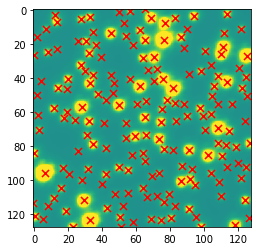

reference difference image


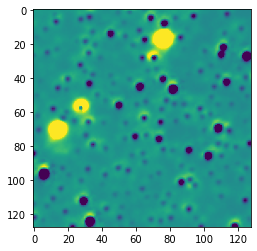

In [349]:
# STEP 9: Run a forced fit using centered new image, weight, and relative xys

psf_ = psf.gaussian_psf(4, deriv=False) # get the psf stamps
psf_ = np.reshape(psf_, (19, 19)) # reshape the psf into the shape the SimplePSF object needs.
psf__ = psf.SimplePSF(psf_) # make a SimplePSF psf object with the stamps.

psf__ = psf.MoffatPSF(4, beta=3)
    
#CROWDSOURCE GET XS AND YS
pars_ = crowdsource_base.fit_im_force(subim, 
                                 ys_, xs_, 
                                 psf__, weight = weight, psfderiv = False, derivcentroids=False, refit_psf=True, refit_sky = True, startsky = 0) # Do the forced fit
  
print("starting reference image")
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.show()

print("reference model image")
plt.imshow(pars[1], vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference difference image")
plt.imshow(subim - pars[1], vmin=-1600, vmax=1600 )
plt.show()

Extension None, iteration  1, found     62 sources;    0 close and    0 faint sources removed.
Extension None, iteration  2, found     16 sources;    0 close and    0 faint sources removed.
Extension None, iteration  3, found     27 sources;    1 close and    1 faint sources removed.
Extension None, iteration  4, found      4 sources;    0 close and    0 faint sources removed.
starting reference image


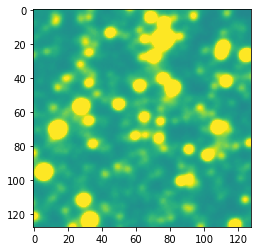

reference model image


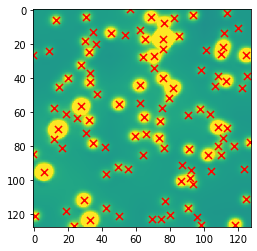

reference difference image


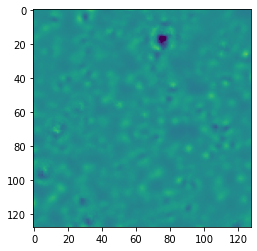

reference model image


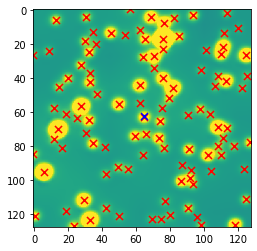

(270.31178, -28.7764) [[270.30649982 270.30678432 270.30675115 270.30693864 270.30703481
  270.30753713 270.30782634 270.3078056  270.30795589 270.30814973
  270.30847762 270.30850504 270.30834857 270.3086427  270.30855836
  270.30866563 270.30911484 270.30973117 270.30979654 270.30997666
  270.30983086 270.31009588 270.31020743 270.3101954  270.31055793
  270.31102094 270.31115263 270.31126491 270.31121414 270.31164546
  270.31184259 270.31184593 270.31209478 270.31228821 270.31247713
  270.31256062 270.31266098 270.31283314 270.31295963 270.3129972
  270.31320111 270.31351468 270.31345751 270.31410588 270.31438281
  270.31446021 270.31475193 270.31573335 270.31561744 270.31574303
  270.31607536 270.31613658 270.31654055 270.31651084 270.31644093
  270.316701   270.31662083 270.31665912 270.31692379 270.31687031
  270.31701915 270.30807248 270.30850877 270.30869775 270.30924164
  270.30949656 270.31072398 270.31153143 270.31146754 270.31212136
  270.31313935 270.31314649 270.31302362 

In [332]:
# Crowdsource on Reference Image

psf_ = psf.gaussian_psf(4, deriv=False) # get the psf stamps
psf_ = np.reshape(psf_, (19, 19)) # reshape the psf into the shape the SimplePSF object needs.
psf__ = psf.SimplePSF(psf_) # make a SimplePSF psf object with the stamps.
    
#CROWDSOURCE GET XS AND YS
pars = crowdsource_base.fit_im(subim, psf__, weight=weight, 
                           verbose=True, miniter=4, maxiter=10, 
                           refit_psf=True, derivcentroids=True) # Get the crowdsource fit (including sky subtraction).


print("starting reference image")
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.show()

print("reference model image")
plt.imshow(pars[1], vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference difference image")
plt.imshow(subim - pars[1], vmin=-1600, vmax=1600 )
plt.show()


# Transform xs and ys back

x = pars[0]["x"] + xmin
y = pars[0]["y"] + ymin

#print(x, y)
#print(c)

# x = pars[0]["x"]
# y = pars[0]["y"]
radecs = np.transpose(q.get_radec_from_xy(np.transpose(np.array([list(y), list(x)]))))

#print(radecs)
#print(radec)

im = imhdul[1].data

# Plot the original radec over this.
ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
xy = ws.wcs_world2pix(np.array([[radec[0], radec[1]]]), 0)  # return the Ra/Dec positions as a numpy array

x = xy[0][0]
y = xy[0][1]
xrel = x - ymin
yrel = 2*s - (y - xmin) - 1



print("reference model image")
plt.imshow(pars[1], vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.scatter(xrel, yrel, s=50, color = "blue", alpha = 1, marker = "x")
plt.show()

#print(xy, xrel, yrel, xmin, ymin)

print(radec, radecs)

print(radecs.shape)

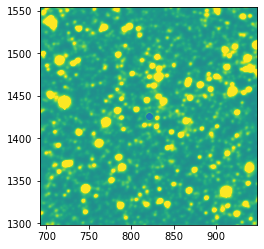

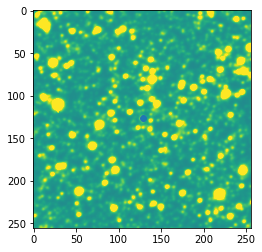

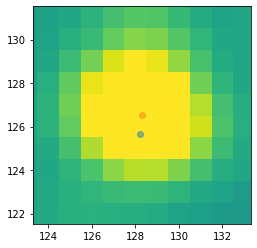

(270.31177, -28.776405) [[270.30096358 270.30116607 270.30115089 ... 270.32022249 270.32094058
  270.32103836]
 [-28.77820169 -28.77163707 -28.77357741 ... -28.78272423 -28.77791533
  -28.78287703]]
fluffy


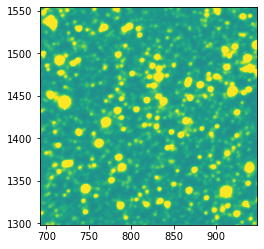

In [75]:


#Plot the xys on another image.

# First, get image submim and weight subim
imhdul = fits.open(imfnames[6])
im = imhdul[1].data

whdul = fits.open(wfnames[6])
w = whdul[1].data

# Get pixel coordinates for image
radec = (270.31177, -28.776405) # Repasted from above because I forgot

ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
xy = ws.wcs_world2pix(np.array([[radec[0], radec[1]]]), 0)  # return the Ra/Dec positions as a numpy array

x = xy[0][0]
y = xy[0][1]

# print(xy)

#  Make the tile for image with xlim
xmin, xmax, ymin, ymax = int(x - s), int(x + s), int(y - s), int(y + s)

plt.imshow(im, vmin = -1600, vmax = 1600)
plt.scatter(x, y)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()


# Make the tile for image with indexing
sub = np.flipud(im[ymin:ymax, xmin:xmax])
weight = np.flipud(w[ymin:ymax, xmin:xmax])

xrel_ = x - xmin
yrel_ = y - ymin
# print(yrel_)
yrel_ = 2*s - yrel_-1

plt.imshow(sub, vmin = -1600, vmax = 1600)
# plt.scatter(x - xmin, 2*s - (y - ymin))
plt.scatter(xrel_, yrel_)
plt.show()


# Alright. Got correct tile. Now convert radecs to pixels the same way you did above.
ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
xy_ = ws.wcs_world2pix(np.transpose(np.array([radecs[0], radecs[1]])), 0)  # return the Ra/Dec positions as a numpy array

# print("xy_")
# print(xy_)
# print(x, y)

# ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
# xy_ = ws.wcs_world2pix(np.array([[radec[0], radec[1]]]), 0)  # return the Ra/Dec positions as a numpy array

xy_ = np.transpose(xy_)

x = xy_[0]
y = xy_[1]

# print(x, y)
# print(xmin, ymin)
# print(x - xmin, y - ymin)

xrel = x - xmin
yrel = y - ymin
#yrel = 2*s - yrel-1
#xrel = 2*s - xrel - 1
dec = yrel - yrel.astype(int)
rec = 1 - dec

lint = abs(yrel - yrel_)
diffy = min(lint)
index = list(lint).index(diffy)
diffy = (yrel - yrel_)[index]

lint = abs(xrel - xrel_)
diffx = min(lint)
index = list(lint).index(diffx)
diffx = (xrel - xrel_)[index]


#Plot it
plt.imshow(sub, vmin = -1600, vmax = 1600)
plt.scatter(xrel, yrel, alpha = 0.5)
plt.scatter(xrel_, yrel_, alpha = 0.5)
plt.xlim(xrel_ - 5, xrel_ + 5)
plt.ylim(yrel_ - 5, yrel_ + 5)
plt.show()
print(radec, radecs)
print("fluffy")
# print(xy)
# print(xy_)

# Hmmm. Plot the x and ys with xlim

plt.imshow(im, vmin = -1600, vmax = 1600)
#plt.scatter(x, y)
plt.scatter(xy[0][1], xy[0][0])
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

Iteration 1, median sky   0.00
Iteration 2, median sky  77.78
Iteration 3, median sky  76.98
Iteration 4, median sky  99.42
forced image


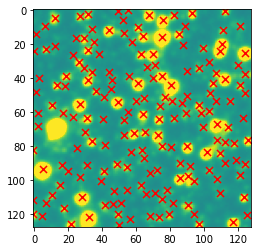

forced model image


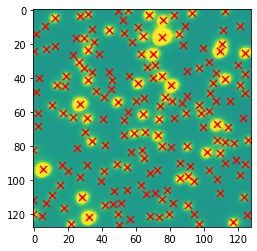

forced difference image


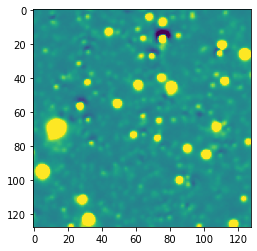

In [270]:
# Run forced crowdsource on this image

# Crowdsource on Reference Image

#MAKE PSF OBJECT
psf__ = psf.MoffatPSF(4, beta=3)
    
#CROWDSOURCE GET XS AND YS
pars_ = crowdsource_base.fit_im_force(sub, 
                                 yrel, xrel, 
                                 psf__, weight = weight, psfderiv = False, derivcentroids=False, refit_psf=True, refit_sky = True, startsky = 0) # Do the forced fit
    

print("forced image")
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.scatter(xrel, yrel, s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("forced model image")
plt.imshow(pars_[1], vmin=-1600, vmax=1600 )
plt.scatter(pars_[0]["y"], pars_[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("forced difference image")
plt.imshow(subim - pars_[1], vmin=-1600, vmax=1600 )
plt.show()

In [ ]:
# I think it looks good/alright? There is some dipole-ing but don't know what to do about that yet.
# Plotting other images:

for i in range(len(imfnames[:10])):
    imhdul = fits.open(imfnames[i])
    whdul = fits.open(wfnames[i])


    q = Quadrant(imhdul, (64, 64)) # start a tile
    xy = q.get_xy_from_radec(np.array([[radec[0], radec[1]]])) # convert radec to pixel values


    # PLOT QUADRANT IMAGE
    subim, ymin, ymax, xmin, xmax = q.get_centered_im(radec[0], radec[1]) # Get the image centered on the int near radect
    plt.imshow(subim, vmin=-1600, vmax=1600)


    # Run forced crowdsource on this image

    # Crowdsource on Reference Image
    x = pars[0]["x"]
    y = pars[0]["y"]

    #MAKE PSF OBJECT
    psf__ = psf.MoffatPSF(4, beta=3)

    #CROWDSOURCE GET XS AND YS
    pars_ = crowdsource_base.fit_im_force(subim, 
                                     x, y, 
                                     psf__, weight = weight, psfderiv = False, derivcentroids=False, refit_psf=True, refit_sky = False, startsky = 0) # Do the forced fit
    
    print("forced difference image 1")
    plt.imshow(subim - pars_[1], vmin=-1600, vmax=1600 )
    plt.show()